In [97]:
API_KEY = 'your-eodhd-api-here'
tickers = ['NESN.SW', 'MDLZ.US', 'HSY.US', 'GIS.US', 'KHC.US']  # EODHD requires US suffix for US markets

# Constants for the number of days before earnings and after dividend
DAYS_AFTER_DIVIDEND = 0  # Number of days after the dividend to buy
DAYS_BEFORE_EARNINGS = 0  # Number of days before earnings to sell

# Define the period of analysis
start_date = '2020-01-01'
end_date = '2025-01-01'

# Initial nominal investment in each stock
initial_investment = 1000

In [98]:
# Block 2: Data Retrieval

import requests
import io
import pandas as pd

# Helper function to download price data from the API
def fetch_price_data(ticker):
    prices_url = f"https://eodhd.com/api/eod/{ticker}?from={start_date}&to={end_date}&api_token={API_KEY}&fmt=json"
    response = requests.get(prices_url)
    
    if response.status_code == 200:
        prices = pd.read_json(io.StringIO(response.text))
        prices['date'] = pd.to_datetime(prices['date'])
        prices.set_index('date', inplace=True)
        # Print diagnostics for earnings dates
        print(prices)
        return prices[['close']]  # Only return the 'close' price column
    else:
        print(f"Error fetching prices for {ticker}: {response.status_code}")
        return pd.DataFrame()

# Helper function to download earnings data from the API
def fetch_earnings_data(ticker):
    earnings_url = f"https://eodhd.com/api/calendar/earnings?api_token={API_KEY}&from={start_date}&to={end_date}&symbols={ticker}"
    response = requests.get(earnings_url)
    
    if response.status_code == 200 and response.text.strip() != "":
        try:
            earnings = pd.read_csv(io.StringIO(response.text))
            earnings_dates = earnings['Report_Date'].dropna().unique()
            # Print diagnostics for earnings dates
            earnings_dates_str = ', '.join(earnings_dates)
            print(f"Earnings Dates for {ticker}: {earnings_dates_str}")
            return earnings_dates
        except Exception as e:
            print(f"Error processing earnings data for {ticker}: {e}")
            return []
    else:
        print(f"Error fetching earnings for {ticker}: {response.status_code}")
        return []

# Helper function to download dividend data from the API
def fetch_dividend_data(ticker):
    dividends_url = f"https://eodhd.com/api/div/{ticker}?from={start_date}&to={end_date}&api_token={API_KEY}&fmt=json"
    response = requests.get(dividends_url)

    if response.status_code == 200 and response.text.strip() != "":
        try:
            dividends = response.json()
            dividend_dates = [pd.to_datetime(item['date']) for item in dividends if 'date' in item]
            # Print diagnostics for dividend dates
            dividend_dates_str = ', '.join([date.strftime('%Y-%m-%d') for date in dividend_dates])
            print(f"Dividend Dates for {ticker}: {dividend_dates_str}")
            return dividend_dates
        except Exception as e:
            print(f"Error processing dividend data for {ticker}: {e}")
            return []
    else:
        print(f"Error fetching dividends for {ticker}: {response.status_code}")
        return []

# Placeholder for downloaded data
downloaded_data = {}

# Open a file to log CSV data
    
# Fetch prices, earnings, and dividends for each stock
for ticker in tickers:
    print(f"\nFetching data for {ticker}...")

    # Fetch the prices, earnings, and dividends
    prices_df = fetch_price_data(ticker)
    earnings_dates = fetch_earnings_data(ticker)
    dividend_dates = fetch_dividend_data(ticker)
    
    # Convert dates to strings for CSV logging
    earnings_dates_str = ', '.join([str(date) for date in earnings_dates])
    dividend_dates_str = ', '.join([date.strftime('%Y-%m-%d') for date in dividend_dates])

    # Store the fetched data for later use
    downloaded_data[ticker] = {
        'prices': prices_df,
        'earnings_dates': earnings_dates,
        'dividends': dividend_dates
    }

print("\nData retrieval completed!")



Fetching data for NESN.SW...
              open    high     low   close  adjusted_close    volume
date                                                                
2020-01-03  104.50  106.66  104.16  106.32         93.1973   6795058
2020-01-06  105.84  106.44  105.22  106.26         93.1447   4768211
2020-01-07  106.50  106.92  105.08  105.20         92.2156   5589217
2020-01-08  104.48  104.76  103.50  103.50         90.7254   7253575
2020-01-09  103.80  103.94  102.94  103.08         90.3572   7964898
2020-01-10  103.18  103.66  102.94  102.94         90.2345   5028786
2020-01-13  102.92  103.98  102.82  103.54         90.7604   4350059
2020-01-14  103.54  103.62  102.66  103.42         90.6553   7576903
2020-01-15  103.00  104.16  102.82  103.82         91.0059   6997259
2020-01-16  103.70  104.94  103.60  104.90         91.9526   5080243
2020-01-17  104.90  106.78  104.78  106.58         93.4252   7555659
2020-01-20  106.50  107.52  106.20  106.90         93.7057   4034669
2020

In [99]:
# Helper function to find the nearest valid date for price lookup
def get_nearest_date(df, target_date):
    if target_date in df.index:
        return target_date
    nearest_idx = df.index.get_indexer([target_date], method='nearest')
    nearest_date = df.index[nearest_idx[0]]
    return nearest_date

# Placeholder for cumulative returns data and nominal investment values
investment_data = {}
diagnostic_data = []

# Loop over each stock and simulate the strategy
for ticker, data in downloaded_data.items():
    print(f"\nProcessing {ticker} for strategy...")  # Diagnostic output
    
    # Extract the relevant data
    df = data['prices']
    dividends = data['dividends']
    earnings_dates = data['earnings_dates']
    
    # Ensure that we have earnings dates and dividends data to process
    if len(earnings_dates) == 0:  # Check if earnings_dates is empty
        print(f"No earnings dates available for {ticker}. Skipping...")
        continue

    if len(dividends) == 0:  # Check if dividends is empty
        print(f"No dividend data available for {ticker}. Skipping...")
        continue

    # Now, simulate the buy-sell strategy
    cumulative_investment = initial_investment  # Start with $1,000 initial investment
    cumulative_values = []  # Track cumulative value after each trade
    trade_dates = []  # Track the trade dates
    
    for ex_dividend_date in dividends:
        try:
            # Ensure ex_dividend_date is timezone-naive (just in case)
            ex_dividend_date = pd.Timestamp(ex_dividend_date).tz_localize(None)
            
            # Find the nearest valid date to buy a certain number of days after the ex-dividend date
            buy_date = get_nearest_date(df, ex_dividend_date + pd.DateOffset(days=DAYS_AFTER_DIVIDEND))
            buy_price = df.loc[buy_date]['close']
            
            # Get the next earnings date and sell a certain number of days before it
            next_earnings_dates = [pd.Timestamp(date) for date in earnings_dates if pd.Timestamp(date) > buy_date]
            if not next_earnings_dates:
                print(f"No future earnings date available for {ticker} after {buy_date}")
                continue
            
            next_earnings_date = min(next_earnings_dates)
            sell_date = get_nearest_date(df, next_earnings_date - pd.DateOffset(days=DAYS_BEFORE_EARNINGS))
            sell_price = df.loc[sell_date]['close']
            
            # Calculate percentage return for this trade
            trade_return = (sell_price - buy_price) / buy_price * 100
            cumulative_value = cumulative_investment * (1 + (trade_return / 100))
            
            # Diagnostic: Print buy/sell details, % gain, and cumulative funds
            print(f"Trade on {ticker}: Buy on {buy_date} at {buy_price:.2f}, Sell on {sell_date} at {sell_price:.2f}, "
                  f"Return: {trade_return:.2f}%, Cumulative Value: {cumulative_value:.2f} $")
            
            # Store the result for cumulative investment
            cumulative_values.append(cumulative_value)
            trade_dates.append(sell_date)
            
            # Update cumulative investment for the next trade
            cumulative_investment = cumulative_value
        
        except KeyError as e:
            print(f"KeyError for {ticker}: {e}")
            continue

    # Store cumulative values for the stock over time
    if len(cumulative_values) > 0:
        investment_data[ticker] = pd.Series(cumulative_values, index=trade_dates).groupby(level=0).sum()

print("\nProcessing completed!")



Processing NESN.SW for strategy...
Trade on NESN.SW: Buy on 2020-04-27 00:00:00 at 104.20, Sell on 2020-07-30 00:00:00 at 109.92, Return: 5.49%, Cumulative Value: 1054.89 $
Trade on NESN.SW: Buy on 2021-04-19 00:00:00 at 106.48, Sell on 2021-07-29 00:00:00 at 113.70, Return: 6.78%, Cumulative Value: 1126.42 $
Trade on NESN.SW: Buy on 2022-04-11 00:00:00 at 124.08, Sell on 2022-07-28 00:00:00 at 117.00, Return: -5.71%, Cumulative Value: 1062.15 $
Trade on NESN.SW: Buy on 2023-04-24 00:00:00 at 114.66, Sell on 2023-07-27 00:00:00 at 108.00, Return: -5.81%, Cumulative Value: 1000.45 $
Trade on NESN.SW: Buy on 2024-04-22 00:00:00 at 93.84, Sell on 2024-09-06 00:00:00 at 87.54, Return: -6.71%, Cumulative Value: 933.29 $

Processing MDLZ.US for strategy...
Trade on MDLZ.US: Buy on 2020-03-30 00:00:00 at 51.13, Sell on 2020-04-28 00:00:00 at 51.17, Return: 0.08%, Cumulative Value: 1000.78 $
Trade on MDLZ.US: Buy on 2020-06-29 00:00:00 at 50.58, Sell on 2020-07-28 00:00:00 at 55.71, Return: 1

Investment Data to be plotted:
                NESN.SW      MDLZ.US       HSY.US       GIS.US       KHC.US
2019-12-31  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000
2020-03-18          NaN          NaN          NaN  1102.520046          NaN
2020-04-23          NaN          NaN   855.099619          NaN          NaN
2020-04-28          NaN  1000.782320          NaN          NaN          NaN
2020-04-30          NaN          NaN          NaN          NaN  1511.964108
2020-07-01          NaN          NaN          NaN  1195.501281          NaN
2020-07-23          NaN          NaN   977.323496          NaN          NaN
2020-07-28          NaN  1102.285153          NaN          NaN          NaN
2020-07-30  1054.894434          NaN          NaN          NaN  1710.972217
2020-09-23          NaN          NaN          NaN  1103.186793          NaN
2020-10-29          NaN          NaN          NaN          NaN  1478.642272
2020-11-02          NaN  1060.520099          NaN        

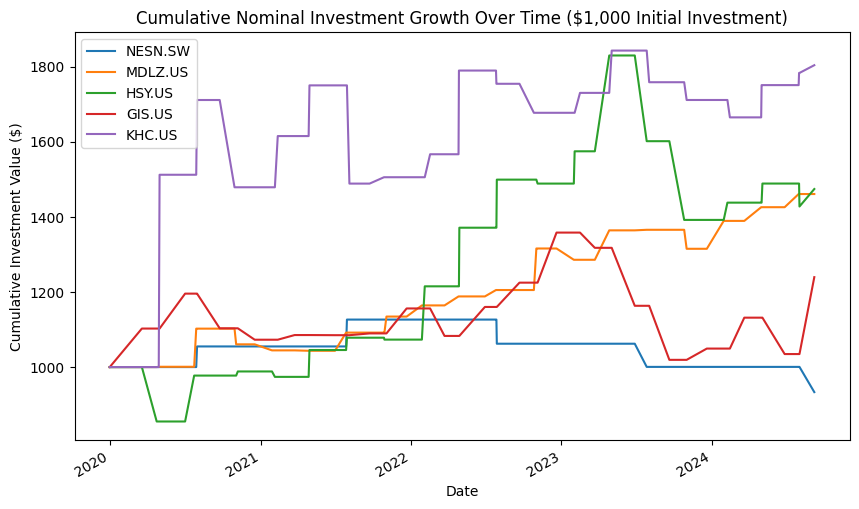

In [100]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt

# Create DataFrame for nominal dollar values
investment_df = pd.DataFrame(investment_data)

# Calculate the day before the start date dynamically
initial_investment_date = pd.to_datetime(start_date) - pd.Timedelta(days=1)  # Subtract one day

# Add a row for the day before the start of the simulation
initial_investment_row = pd.Series({ticker: 1000 for ticker in investment_df.columns}, name=initial_investment_date)

# Insert the row into the DataFrame
investment_df = pd.concat([pd.DataFrame([initial_investment_row]), investment_df])

print("Investment Data to be plotted:")
print(investment_df)

# Forward fill to handle NaN values
investment_df.ffill(inplace=True)

# Plot the cumulative nominal investment values over time
fig, ax = plt.subplots(figsize=(10, 6))
investment_df.plot(kind='line', ax=ax, title='Cumulative Nominal Investment Growth Over Time ($1,000 Initial Investment)')
plt.ylabel('Cumulative Investment Value ($)')
plt.xlabel('Date')
plt.show()


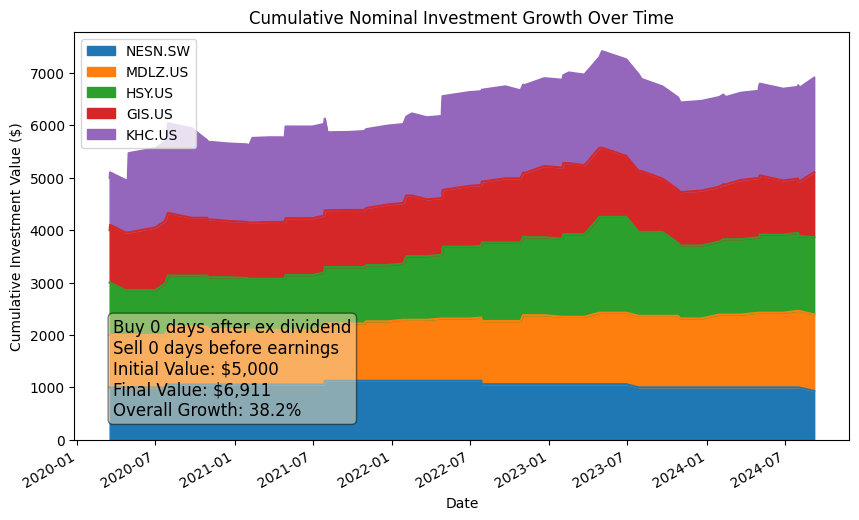

            NESN.SW  MDLZ.US  HSY.US  GIS.US  KHC.US  Subtotal   %
2020-03-17     1000     1000    1000    1000    1000      5000   0
2020-03-18     1000     1000    1000    1103    1000      5103   2
2020-04-23     1000     1000     855    1103    1000      4958  -1
2020-04-28     1000     1001     855    1103    1000      4958  -1
2020-04-30     1000     1001     855    1103    1512      5470   9
2020-07-01     1000     1001     855    1196    1512      5563  11
2020-07-23     1000     1001     977    1196    1512      5686  14
2020-07-28     1000     1102     977    1196    1512      5787  16
2020-07-30     1055     1102     977    1196    1711      6041  21
2020-09-23     1055     1102     977    1103    1711      5949  19
2020-10-29     1055     1102     977    1103    1479      5716  14
2020-11-02     1055     1061     977    1103    1479      5675  13
2020-11-06     1055     1061     988    1103    1479      5686  14
2020-12-17     1055     1061     988    1073    1479      5655

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

# Set display options for maximum visibility
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Set display width to fit your terminal size

# Create DataFrame for nominal dollar values
investment_df = pd.DataFrame(investment_data)

# Calculate the day before the start date dynamically
start_date = investment_df.index.min()  # Get the earliest date in the DataFrame
initial_investment_date = start_date - pd.Timedelta(days=1)  # Subtract one day

# Add a row for the day before the start of the simulation
initial_investment_row = pd.Series({ticker: 1000 for ticker in investment_df.columns}, name=initial_investment_date)

# Insert the row into the DataFrame
investment_df = pd.concat([pd.DataFrame([initial_investment_row]), investment_df])

# Forward fill to handle NaN values
investment_df.ffill(inplace=True)

# Add a 'Subtotal' column that calculates the cumulative investment value across all stocks
investment_df['Subtotal'] = investment_df.sum(axis=1)

# Add a column for cumulative percentage gain
initial_investment = investment_df['Subtotal'].iloc[0]
investment_df['%'] = (investment_df['Subtotal'] - initial_investment) / initial_investment * 100

# Calculate the total initial investment and final investment value
initial_value = investment_df['Subtotal'].iloc[0]  # Sum of investments at the start, from the 'Subtotal' column
final_value = investment_df['Subtotal'].iloc[-1]  # Sum of investments at the end, from the 'Subtotal' column

# Calculate overall growth percentage
growth_percentage = ((final_value - initial_value) / initial_value) * 100

# Plot the stacked area chart with forward-filled data
fig, ax = plt.subplots(figsize=(10, 6))
investment_df.drop(columns=['Subtotal', '%']).plot(kind='area', stacked=True, ax=ax, title='Cumulative Nominal Investment Growth Over Time')
plt.ylabel('Cumulative Investment Value ($)')
plt.xlabel('Date')

# Add a text box with the final value and growth percentage in the bottom-left corner
textstr = f'Buy {DAYS_AFTER_DIVIDEND} days after ex dividend\nSell {DAYS_BEFORE_EARNINGS} days before earnings\nInitial Value: ${initial_value:,.0f}\nFinal Value: ${final_value:,.0f}\nOverall Growth: {growth_percentage:.1f}%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.05, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='bottom', bbox=props)

# Show the plot
plt.show()

# Format the DataFrame to show zero decimal places for all numeric values
formatted_df = investment_df.apply(lambda x: x.round(0).astype(int) if pd.api.types.is_numeric_dtype(x) else x)

# Print the formatted DataFrame
print(formatted_df)